## Testing out some code to hit the NHL API :)


Resources

* https://towardsdatascience.com/nhl-analytics-with-python-6390c5d3206d
* https://nhl-api-explorer.herokuapp.com/
* https://gitlab.com/dword4/nhlapi
* https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md#game-ids
* https://github.com/dword4/nhlapi

Game IDs
* The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season). 
* The next 2 digits give the type of game, where 01 = preseason, 02 = regular season, 03 = playoffs, 04 = all-star. 
* The final 4 digits identify the specific game number. 
* For regular season and preseason games, this ranges from 0001 to the number of games played. (1271 for seasons with 31 teams (2017 and onwards) and 1230 for seasons with 30 teams). 
* For playoff games, the 2nd digit of the specific number gives the round of the playoffs, the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).

In [32]:
# Standard library modules
import datetime
import glob
import json
import math
import os
import shutil
import sys
import time
from enum import Enum

# Third-party libraries
import jsonlines
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import RegularPolygon
from PIL import Image

color_map = plt.cm.winter

### Getting data from the NHL API
- Due to the memory-intensive files, each file has been capped to ~50mb
- Files will share a common prefix followed by an incremental suffix
- The API calls will be looped over the year(s), season type(s) specified, starting from game "0001" up to a specified maximum

In [66]:
class SeasonType(Enum):
    PRE_SEASON = "01"
    REGULAR_SEASON = "02"
    PLAYOFFS = "03"
    ALL_STAR = "04"

class FileHandler:
    """Class to handle writing JSON data to file(s) based on a maximum file size."""    
    
    def __init__(self, max_file_size_bytes, output_folder):
        """Initialize the file handler."""
        self.max_file_size_bytes = max_file_size_bytes
        self.output_folder = output_folder
        self.current_file_size = 0
        self.current_file_index = 1
        self.output_file = self._create_output_file()

    def _create_output_file(self):
        """Summary: Create a new output file.

        Returns:
            str: The full path to the output file.
        """
        output_file = os.path.join(self.output_folder, f'livefeed_{self.current_file_index}.jsonl')
        with open(output_file, 'w') as file:
            pass  # Create an empty file
        return output_file

    def write_to_file(self, json_data):
        """Write the JSON data to file.
        
        Args:
            json_data (dict): The JSON data to write to file.
            
        Returns:
            None
        """
        json_data_str = json.dumps(json_data)
        json_size = len(json_data_str.encode('utf-8'))

        # Check if writing the JSON data would exceed the max file size
        if self.current_file_size + json_size > self.max_file_size_bytes:
            self.current_file_index += 1
            self.current_file_size = 0
            self.output_file = self._create_output_file()
        with open(self.output_file, 'a') as file:
            file.write(json_data_str + '\n')
        
        self.current_file_size += json_size

def call_endpoint(year, season_type, game_id):
    url = f"http://statsapi.web.nhl.com/api/v1/game/{year}{season_type}{game_id}/feed/live"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Error calling {url}: {e}")
    except Exception as e:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - An unexpected error occurred: {e}")

def get_data():
    # Specify the years and season types to get data for
    years = ['2021']  # Add more years as needed
    season_types = [SeasonType.REGULAR_SEASON]

    # Generate game IDs from "0001" to "1313"
    game_ids = [str(i).zfill(4) for i in range(1, 100)] # TODO: Change this to 1314

    # Specify the maximum file size (in bytes) before splitting
    max_file_size_bytes = 50 * 1024 * 1024  # 50MB

    # Specify where output files are written to
    output_folder = '.output'

    # Check if the folder already exists, and if so, remove it
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    # Create the folder
    os.makedirs(output_folder, exist_ok=True)

    # Initialize the file handler
    file_handler = FileHandler(max_file_size_bytes, output_folder)

    # Initialize a timer
    start_time = time.time()
    interval = 10

    # For each year, season type, and game ID, call the API and write the data to file
    for year in years:
        for season_type in season_types:
            print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Getting data for {year} {season_type.name}")
            for game_id in game_ids:
                
                # Print the current game ID every 10 seconds for progress tracking
                current_time = time.time()
                if current_time - start_time >= interval:
                    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Current game_id: {game_id}")
                    start_time = current_time

                # Call the API
                res = call_endpoint(year, season_type.value, game_id)
                    
                if res is None:
                    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Reached the end of possible game data for {year} {season_type.name}.")
                    break
                
                if res is not None:
                    del res['gameData']
                    del res['liveData']['linescore']
                    del res['liveData']['boxscore']
                    del res['liveData']['decisions']
                    file_handler.write_to_file(res)


In [67]:
get_data()

2023-09-03 10:43:01 - Getting data for 2021 REGULAR_SEASON
2023-09-03 10:43:04 - Error calling http://statsapi.web.nhl.com/api/v1/game/2021021313/feed/live: 404 Client Error: Not Found for url: http://statsapi.web.nhl.com/api/v1/game/2021021313/feed/live
2023-09-03 10:43:04 - Reached the end of possible game data for 2021 REGULAR_SEASON.
2023-09-03 10:43:04 - Getting data for 2022 REGULAR_SEASON
2023-09-03 10:43:06 - Error calling http://statsapi.web.nhl.com/api/v1/game/2022021313/feed/live: 404 Client Error: Not Found for url: http://statsapi.web.nhl.com/api/v1/game/2022021313/feed/live
2023-09-03 10:43:06 - Reached the end of possible game data for 2022 REGULAR_SEASON.


In [ ]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
def get_shot_goal_data(player_names=[]):

    # Match files with glob pattern
    pattern = os.path.join('.output', 'livefeed_*.jsonl')
    matching_files = glob.glob(pattern)
    
    # Set the event types of interest
    event_types = ['Shot','Goal']

    # Coordinates D1
    play_coordinates = {}
    play_coordinates['Shot'] = {}
    play_coordinates['Shot']['x'] = []
    play_coordinates['Shot']['y'] = []
    play_coordinates['Goal'] = {}
    play_coordinates['Goal']['x'] = []
    play_coordinates['Goal']['y'] = []

    # Coordinates D2
    play_coordinates_for_dataframe = {
        "game_id": [],
        "play_id": [],
        "x_coord":[], 
        "y_coord":[], 
        "event":[],
        "event_type":[],
        "event_desc": [],
        "period": [],
        "period_time": [],
        "player_name": [],
        "player_id": [],
        "player_type": []
        }

    # For each matching file
    for file_path in matching_files:

        # Open the file
        with jsonlines.open(file_path, 'r') as file:

            # Each line in the file represents a single game
            for jsonline in file:

                # Skip if no live data for current game
                if 'liveData' not in jsonline.keys():
                    continue

                # Get the plays from each game
                plays = jsonline['liveData']['plays']['allPlays']
                game_id = jsonline['gamePk']

                # Loop over each play in the current game
                for play in plays:
                    
                    # Look for players in the play
                    if 'players' in play:

                        for player in play['players']:
                        
                            if len(player_names) > 0:
                                
                                # If player names are specified, skip any plays that don't involve those players
                                if not any(player_name in player['player']['fullName'] for player_name in player_names):
                                    continue

                            if player['playerType'] in ['Shooter', 'Scorer']:
                                player_type = player['playerType']
                                player_id = player['player']['id']
                                player_name = player['player']['fullName']

                                for event in event_types:
                                    # Look for Shot and Goal events that have coordinates
                                    if play['result']['event'] in event and play['coordinates']:
                                        # Save the coordinates to d1
                                        play_coordinates[event]['x'].append(play['coordinates']['x'])
                                        play_coordinates[event]['y'].append(play['coordinates']['y'])
                                        # Save the coordinates to d2
                                        play_coordinates_for_dataframe["game_id"].append(game_id)
                                        play_coordinates_for_dataframe["x_coord"].append(play['coordinates']['x'])
                                        play_coordinates_for_dataframe["y_coord"].append(play['coordinates']['y'])
                                        play_coordinates_for_dataframe["event"].append(play['result']['event'])
                                        play_coordinates_for_dataframe["event_type"].append(play['result'].get('secondaryType', None))
                                        play_coordinates_for_dataframe["event_desc"].append(play['result']['description'])
                                        play_coordinates_for_dataframe["period"].append(play['about']['period'])
                                        play_coordinates_for_dataframe["period_time"].append(play['about']['periodTime'])
                                        play_coordinates_for_dataframe["play_id"].append(play['about']['eventIdx'])
                                        play_coordinates_for_dataframe["player_name"].append(player_name)
                                        play_coordinates_for_dataframe["player_id"].append(player_id)
                                        play_coordinates_for_dataframe["player_type"].append(player_type)

    # Convert to pandas dataframe
    play_coordinates_df = pd.DataFrame.from_dict(play_coordinates_for_dataframe)

    # Drop dups
    play_coordinates_dedupe_df = play_coordinates_df.drop_duplicates()

    # Add some features
    play_coordinates_dedupe_df['goal'] = np.where(play_coordinates_dedupe_df['event']== 'Goal', 1, 0)
    play_coordinates_dedupe_df['league'] = 'NHL'

    # See data
    return play_coordinates, play_coordinates_dedupe_df

# League data, pass player_names as an empty list
league_coordinates, league_coordinates_df = get_shot_goal_data(player_names=[])

# Play data, specify player_names
player_coordinates, player_coordinates_df = get_shot_goal_data(player_names=['William Nylander'])

player_coordinates_df.head(5)

## Analyzing shots & goals

In [26]:
# Get player summaries
player_shots = player_coordinates_df.groupby(['player_name', 'player_id', 'league']).agg({'goal':['count', 'sum']})
player_shots.columns = ["_".join(x) for x in player_shots.columns.ravel()]
player_shots = player_shots.rename(columns = {"goal_count": "sog", "goal_sum": "goals"})
player_shots = player_shots.reset_index()
player_shots['conversion'] = round(player_shots['goals'] / player_shots['sog'], 4)

# Get league summaries
league_shots = league_coordinates_df.groupby('league').agg({'goal':['count', 'sum']})
league_shots.columns = ["_".join(x) for x in league_shots.columns.ravel()]
league_shots = league_shots.rename(columns = {"goal_count": "sog", "goal_sum": "goals"})
league_shots = league_shots.reset_index()
league_shots['conversion'] = round(league_shots['goals'] / league_shots['sog'], 4)

# Join player summaries with league summaries
df3 = player_shots.merge(league_shots, on = "league", suffixes = ("_player", "_league"))
df3["conv_spread"] = df3["conversion_player"] - df3["conversion_league"]
df3.sort_values(by = "sog_player", ascending = False).head(10)

,player_name,player_id,league,sog_player,goals_player,conversion_player,sog_league,goals_league,conversion_league,conv_spread
0,William Nylander,8477939,NHL,29,3,0.1034,6203,609,0.0982,0.0052


## Shot location analysis

What we are going to do first is set up a binning grid. I want to understand where shots are taken on the ice, but I do not want to see all individual shots. By taking spatial average we can make a more insightful and visual representation. The position data from the API extends from:

* X: -100 to 100 (meters)
* Y: -42.5 to 42.5 (meters)


For our binning we are using hex plots from matplotlib to extract the raw binning data and will use drawn rectangles (again matplotlib) for the final visuals.
To start we define our figure dimensions and grid size:

Next we will find the efficiency of the league at each location on the ice. To do this we call the hexbin method and extract the location vertex and count data.

**Once thing to note is that since the scorer never scores on their own net we must make sure the negative locations are flipped to always represent the attacking side.**

This is all because every period the player switch sides and the coordinate system is fixed.

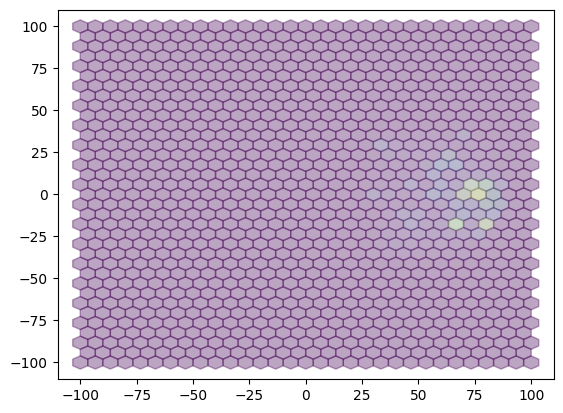

In [27]:
# First concatenate the arrays for x and y league data

def get_normalized_shots_goals(dictionary):
    x_all_shots = dictionary['Shot']['x'] + dictionary['Goal']['x']
    y_all_shots = dictionary['Shot']['y'] + dictionary['Goal']['y']
    
    # Perform the coordinate flipping!
    x_all_shots_normalized = []
    y_all_shots_normalized = []
    
    # Enumerate the list so we can use the index for y also
    for i, s in enumerate(x_all_shots):
        if x_all_shots[i] < 0:
            x_all_shots_normalized.append(-x_all_shots[i])
            y_all_shots_normalized.append(-y_all_shots[i])
        else:
            x_all_shots_normalized.append(x_all_shots[i])
            y_all_shots_normalized.append(y_all_shots[i])
            
    # Do the same treatment for the goals
    x_goal_normalized = []
    y_goal_normalized = []
    
    for i, s in enumerate(dictionary['Goal']['x']):
        if dictionary['Goal']['x'][i] < 0:
            x_goal_normalized.append(-dictionary['Goal']['x'][i])
            y_goal_normalized.append(-dictionary['Goal']['y'][i])
        else:
            x_goal_normalized.append(dictionary['Goal']['x'][i])
            y_goal_normalized.append(dictionary['Goal']['y'][i])
    
    return x_all_shots_normalized, y_all_shots_normalized, x_goal_normalized, y_goal_normalized

def get_shot_goal_hex_data(dictionary):

    # To keep the aspect ratio correct we use a square figure size
    xbnds = np.array([-100.,100.0])
    ybnds = np.array([-100,100])
    extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
    # We are going to bin in 30 unit increments.  It is fun to play with this!  
    gridsize= 30;mincnt=0

    # Get normalized data from previous function
    x_all_shots_normalized, y_all_shots_normalized, x_goal_normalized, y_goal_normalized = get_normalized_shots_goals(dictionary)

    # First we will used the hexbin function to simply bucket our shot data into basically a 2D histogram
    hex_data = plt.hexbin(x_all_shots_normalized,
                          y_all_shots_normalized,
                          gridsize = gridsize,
                          extent = extent,
                          mincnt = mincnt,
                          alpha = 0.1)

    # Now we extract the bin coordinates and counts
    verts = hex_data.get_offsets()
    shot_frequency = hex_data.get_array()

    # Do the same thing for the goal data
    goal_hex_data =  plt.hexbin(x_goal_normalized,
                                y_goal_normalized,
                                gridsize = gridsize,
                                extent = extent,
                                mincnt = mincnt,
                                alpha = 0.1)

    # Since the grid is the same we can use a shared bin coordinate set from the above. So here we just get the counts
    goal_frequency = goal_hex_data.get_array()

    return hex_data, goal_hex_data, verts, shot_frequency, goal_frequency

league_hex_data, league_goal_hex_data, league_verts, league_shot_frequency, league_goal_frequency = get_shot_goal_hex_data(league_coordinates)
player_hex_data, player_goal_hex_data, player_verts, player_shot_frequency, player_goal_frequency = get_shot_goal_hex_data(player_coordinates)

In [29]:
class IcePlotter:
    def __init__(
        self,
        player_verts,
        player_shot_frequency,
        player_goal_frequency,
        league_verts,
        league_shot_frequency,
        league_goal_frequency
        ):
        
        self.player_verts = player_verts
        self.player_shot_frequency = player_shot_frequency
        self.player_goal_frequency = player_goal_frequency
        self.league_verts = league_verts
        self.league_shot_frequency = league_shot_frequency
        self.league_goal_frequency = league_goal_frequency

        # Initialize the plot
        self.fig = plt.figure(figsize=(10, 10))
        self.ax = self.fig.add_subplot(111)
        self.ax.set_facecolor("white")
        self.fig.patch.set_facecolor("white")
        self.fig.patch.set_alpha(0.0)
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        # Using pillow to get the rink image and extract the image size
        self.I = Image.open('nhl_arena.png')
        self.ax.imshow(self.I)
        self.width, self.height = self.I.size

        # Calculate the scaling factor and offset (trial and error)
        self.scalingx = self.width / 100 - 0.6
        self.scalingy = self.height / 100 + 0.5
        self.x_trans = 33
        self.y_trans = self.height / 2

        # We will want to scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
        self.S = 3.8 * self.scalingx

        # Define positive and negative colour mappings
        self.positive_cm = self._color_converter('#e1e5e5', '#d63b36')
        self.negative_cm = self._color_converter('#e1e5e5', '#28aee4')

    # Custom colour map
    def _color_converter(self, hex_code1, hex_code2):
        c = mcolors.ColorConverter()
        x = ListedColormap([c.to_rgb(hex_code1),c.to_rgb(hex_code2)])
        return x

    def plot_shots(self, shot_frequency, alpha=0.5, color='blue', is_comparison_plot=False):
        for i, v in enumerate(self.league_verts):
            # Ignore empty locations
            if shot_frequency[i] < 1:
                continue

            # Normalize the shot frequency data between 0-1
            scaled_shot_frequency = shot_frequency[i] / max(shot_frequency)

            # Scale the hexagon size based on shot frequency
            radius = self.S * math.sqrt(scaled_shot_frequency)

            if is_comparison_plot:
                # Find the player efficiency and relative at this point on the ice.
                player_efficiency = self.player_goal_frequency[i] / self.player_shot_frequency[i]
                league_efficiency = self.league_goal_frequency[i] / self.league_shot_frequency[i]
                # This is what we were after the whole time!
                relative_efficiency = player_efficiency - league_efficiency

                # Since there can be positive and negative efficiencies (relative) we colour the more efficient locations red and the less blue.
                if relative_efficiency > 0:
                    color = self.positive_cm(math.pow(relative_efficiency, 0.1))
                else:
                    color = self.negative_cm(math.pow(-relative_efficiency, 0.1))

            # Finally we will plot the hexagon including the scaling and translations we found earlier
            hex = RegularPolygon((self.x_trans + v[0] * self.scalingx, self.y_trans - v[1] * self.scalingy),
                                numVertices=6,
                                radius=radius,
                                orientation=np.radians(0),
                                alpha=alpha,
                                edgecolor=None,
                                facecolor=color)
            self.ax.add_patch(hex)

    def plot_player_shots(self):
        self.plot_shots(self.player_shot_frequency)

    def plot_league_shots(self):
        self.plot_shots(self.league_shot_frequency)

    def plot_player_shot_comparison(self):
        self.plot_shots(self.player_shot_frequency, alpha=1, is_comparison_plot=True)

    def show_plot(self):
        plt.show()

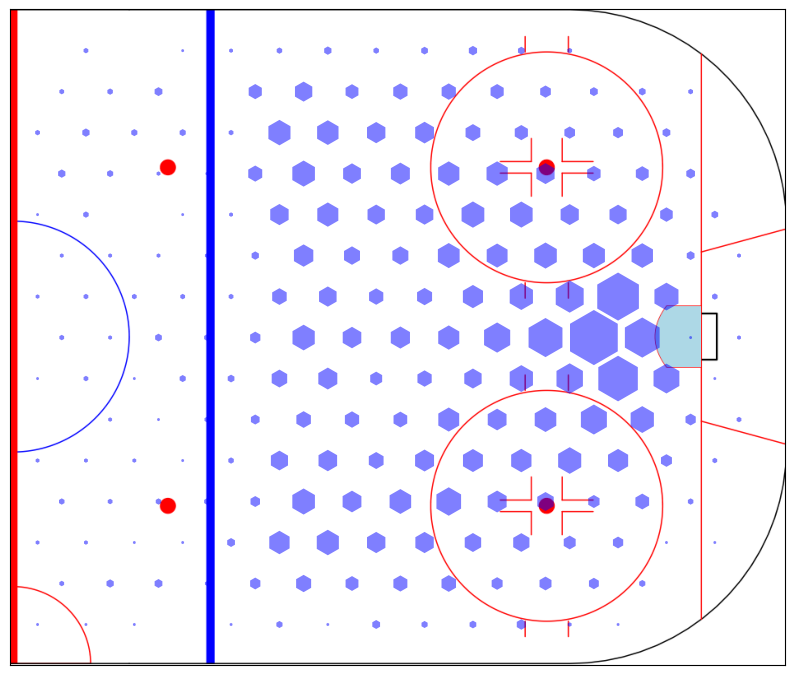

In [18]:

# Usage example of plotting league shots
ice_plotter = IcePlotter(
    player_verts,
    player_shot_frequency,
    player_goal_frequency,
    league_verts,
    league_shot_frequency,
    league_goal_frequency
)
ice_plotter.plot_league_shots()
plt.show()

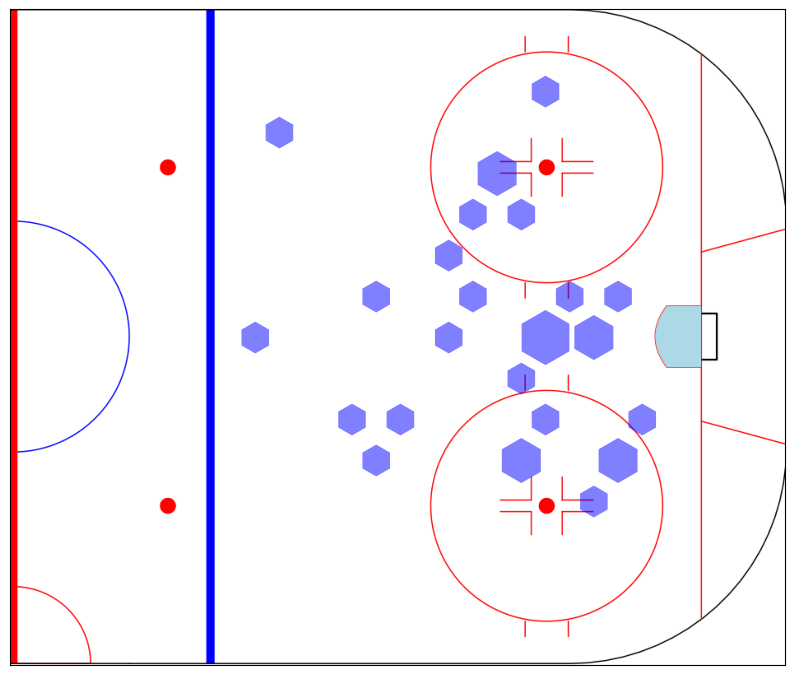

In [30]:
# Usage example of plotting player shots
ice_plotter = IcePlotter(
    player_verts,
    player_shot_frequency,
    player_goal_frequency,
    league_verts,
    league_shot_frequency,
    league_goal_frequency
)
ice_plotter.plot_player_shots()
plt.show()

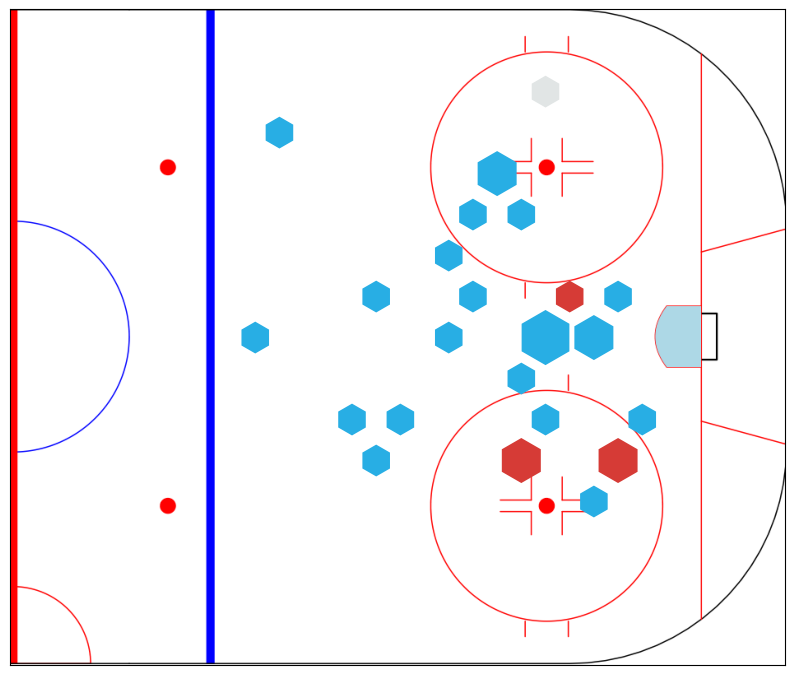

In [31]:
# Usage example of plotting player compared to league shots
ice_plotter = IcePlotter(
    player_verts,
    player_shot_frequency,
    player_goal_frequency,
    league_verts,
    league_shot_frequency,
    league_goal_frequency
)
ice_plotter.plot_player_shot_comparison()
plt.show()